In [2]:
import pandas as pd
import numpy as np
from joblib import dump, load

In [5]:
def sliding_window(weather_df, air_df, window_size=4, target_size="one"):           # target_size is either "one" or "same"
    X = []
    y = []
    w_df = weather_df[:]
    a_df = air_df[:]
    w_df["time"] = pd.to_datetime(w_df["time"])
    a_df["time"] = pd.to_datetime(a_df["time"])
    w_df.set_index("time", inplace=True)
    a_df.set_index("time", inplace=True)
    weather_time_idx = w_df.index
    
    for i in range(window_size - 1, len(weather_df)):
        w_start, w_end = weather_time_idx[i - window_size + 1], weather_time_idx[i]
        if (w_end - w_start).seconds == 3600 * (window_size - 1):
            try:
                if target_size == "one":
                    a_value = a_df.loc[w_end].values
                elif target_size == "same":
                    a_value = a_df.loc[w_start: w_end].values
                    if len(a_value) != window_size:
                        continue 
                    
                w_value = w_df.loc[w_start: w_end].values
                X.append(w_value)
                y.append(a_value)
            except:
                continue
            
    return np.array(X), np.array(y)

In [6]:
city_df = pd.read_csv("data/region/vietnam/cities.csv")
city_df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Ho Chi Minh City,Ho Chi Minh City,10.7756,106.7019,Vietnam,VN,VNM,Hồ Chí Minh,admin,15136000.0,1704774326
1,Hanoi,Hanoi,21.0000,105.8500,Vietnam,VN,VNM,Hà Nội,primary,8246600.0,1704413791
2,Haiphong,Haiphong,20.8651,106.6838,Vietnam,VN,VNM,Hải Phòng,admin,2103500.0,1704000623
3,Cần Thơ,Can Tho,10.0333,105.7833,Vietnam,VN,VNM,Cần Thơ,admin,1237300.0,1704783472
4,Biên Hòa,Bien Hoa,10.9500,106.8167,Vietnam,VN,VNM,Đồng Nai,admin,1104000.0,1704863046
...,...,...,...,...,...,...,...,...,...,...,...
58,Hà Giang,Ha Giang,22.8333,104.9833,Vietnam,VN,VNM,Hà Giang,admin,55559.0,1704495953
59,Bắc Kạn,Bac Kan,22.1333,105.8333,Vietnam,VN,VNM,Bắc Kạn,admin,45036.0,1704000217
60,Lai Châu,Lai Chau,22.3992,103.4392,Vietnam,VN,VNM,Lai Châu,admin,42973.0,1704983526
61,Kon Tum,Kon Tum,14.3544,108.0075,Vietnam,VN,VNM,Kon Tum,admin,NaN,1704988146


In [7]:
city_data = city_df.loc[:, ["lat", "lng", "population"]]
city_data["population"].fillna(city_data["population"].mean(), inplace=True)
city_data

,lat,lng,population
0,10.7756,106.7019,1.513600e+07
1,21.0000,105.8500,8.246600e+06
2,20.8651,106.6838,2.103500e+06
3,10.0333,105.7833,1.237300e+06
4,10.9500,106.8167,1.104000e+06
...,...,...,...
58,22.8333,104.9833,5.555900e+04
59,22.1333,105.8333,4.503600e+04
60,22.3992,103.4392,4.297300e+04
61,14.3544,108.0075,6.586050e+05


In [8]:
weather_np = []
air_np = []

# take some minutes
for i in range(len(city_df)):           #fix this
    city_id = city_df["id"][i]
    air_df = pd.read_csv("data/air_quality/" + str(city_id) + ".csv")
    weather_df = pd.read_csv("data/weather/" + str(city_id) + ".csv")         # data source
    
    air_df = air_df.loc[(air_df.iloc[:, 1:] >= 0).all(axis=1)]
    air_df.drop("aqi", axis=1, inplace=True)
    air_df.reset_index(drop=True, inplace=True)

    weather_df.dropna(axis=0, inplace=True)
    weather_df.reset_index(drop=True, inplace=True)
    
    X, y = sliding_window(weather_df, air_df, target_size="one")
    m = X.shape[0]
    extra_attr = city_data.loc[i]
    X = X.reshape((m, -1))
    lat = np.full((m, 1), extra_attr[0])
    lng = np.full((m, 1), extra_attr[1])
    population = np.full((m, 1), extra_attr[2])
    X = np.hstack((X, lat, lng, population))
    
    weather_np.append(X)
    air_np.append(y)
    
weather_np = np.vstack(weather_np)
air_np = np.vstack(air_np)

In [9]:
dump((weather_np, air_np), "raw_dataset.pkl")

['raw_dataset.pkl']

In [10]:
weather_np, air_np = load("raw_dataset.pkl")

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split

In [32]:
w_small, _ ,air_small, _ = train_test_split(weather_np, air_np, train_size=200000, shuffle=True)

In [33]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, n_jobs=-1, verbose=3))
])

model = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=StandardScaler()
)

In [34]:
model.fit(w_small, air_small)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished


TransformedTargetRegressor(regressor=Pipeline(steps=[('scaler',
                                                      StandardScaler()),
                                                     ('model',
                                                      RandomForestRegressor(n_jobs=-1,
                                                                            verbose=3))]),
                           transformer=StandardScaler())

In [37]:
pred = model.predict(weather_np[10000:10200])

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


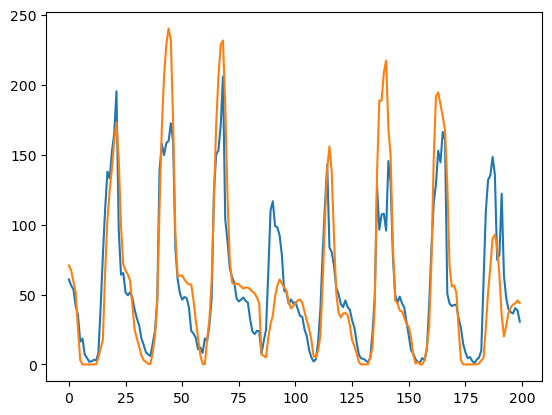

In [40]:
import matplotlib.pyplot as plt
plt.plot(pred[:, 2])
plt.plot(air_np[10000:10200][:, 2])
plt.show()